In [ ]:
import sys
# sys.path.append('../fragnet_edge')
from fragnet.dataset.dataset import FinetuneData
import pandas as pd
from fragnet.dataset.utils import extract_data
import argparse
from omegaconf import OmegaConf
from fragnet.train.utils import TrainerFineTune as Trainer
from fragnet.dataset.data import collate_fn
from torch.utils.data import DataLoader
import torch
from fragnet.dataset.fragments import get_3Dcoords
from fragnet.dataset.fragments import FragmentedMol
from collections import defaultdict
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image
import io
import matplotlib.cm as cm
from fragnet.vizualize.model import FragNetFineTuneViz
import matplotlib.colors as colors
from rdkit import Chem
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit import Geometry
import numpy as np
import config

In [ ]:
# MODEL_CONFIG = config.MODEL_CONFIG
# MODEL_PATH = config.MODEL_PATH


def add_atom_numbers(mol):
        
    for atom in mol.GetAtoms():
        # For each atom, set the property "atomNote" to a index+1 of the atom
        atom.SetProp("atomNote", str(atom.GetIdx()))

def highlight_atoms(smiles, fweights, frag_atoms):

    mol = get_3Dcoords(smiles)
    conf = mol.GetConformer(id=0)
    frag = FragmentedMol(mol, conf)
    mol = frag.mol
    add_atom_numbers(mol)
    mol.RemoveAllConformers()
        
    for m in [mol]:
        rdDepictor.Compute2DCoords(m)
    
    for m in [mol]:
        for atom in m.GetAtoms():
            atom.SetIntProp("SourceAtomIdx",atom.GetIdx())
    
    sourceIdxProperty='SourceAtomIdx'
    

    mol = Chem.Mol(mol)
    tmol= mol
    
    
    # "Tol" colormap from https://davidmathlogic.com/colorblind
    colors = [(51,34,136),(17,119,51),(68,170,153),(136,204,238),(221,204,119),(204,102,119),(170,68,153),(136,34,85)]
    # "IBM" colormap from https://davidmathlogic.com/colorblind
    colors = [(100,143,255),(120,94,240),(220,38,127),(254,97,0),(255,176,0)]
    # Okabe_Ito colormap from https://jfly.uni-koeln.de/color/
    colors = [(230,159,0),(86,180,233),(0,158,115),(240,228,66),(0,114,178),(213,94,0),(204,121,167)]

    colors = cm.rainbow(np.linspace(0, 1, 8))
    # for i,x in enumerate(colors):
    #     colors[i] = tuple(y/255 for y in x)

    
    
    legend=''
    
    fillRings=True
    width=550
    height=400
    
    #----------------------
    # Identify and store which atoms, bonds, and rings we'll be highlighting
    highlightatoms = defaultdict(list)
    highlightbonds = defaultdict(list)
    atomrads = {}
    widthmults = {}
    
    rings = []
    
    d2d = rdMolDraw2D.MolDraw2DCairo(width,height)
    dos = d2d.drawOptions()
    dos.useBWAtomPalette()
    dos.minFontSize = 15

    # dopts = d2d.drawOptions()
    dos.highlightRadius = .15
    # highlightatoms=[]
    # highlightbonds=[]
    for i in range(len(frag.fragments)):
        for j in frag.fragments[i].atom_indices:
            # highlightatoms[j].append(colors[i])
            highlightatoms[j].append(cm.Reds(fweights[i]))
            # highlightatoms[j].append( tuple(colors[i]) )

            # if j in frag_atoms:
            atomrads[j] = .15
            # else:
            #     atomrads[j] = .001
                
                
            
        for j in frag.fragments[i].bond_indices:
            highlightbonds[j].append(cm.Reds(fweights[i]))
            # highlightbonds[j].append( tuple(colors[i]) )
            # widthmults[j] = 20
    
    # highlightatoms = {i:[colors[5]] for i in frag.fragments[1].atom_indices}
    # highlightbonds = {i:[colors[5]] for i in frag.fragments[1].bond_indices}
    
    #----------------------
    # if we are filling rings, go ahead and do that first so that we draw
    # the molecule on top of the filled rings
    if fillRings and rings:
        # a hack to set the molecule scale
        d2d.DrawMoleculeWithHighlights(tmol,legend,dict(highlightatoms),
                                       dict(highlightbonds),
                                       atomrads,widthmults)
        d2d.ClearDrawing()
        conf = tmol.GetConformer()
        for (aring,color) in rings:
            ps = []
            for aidx in aring:
                pos = Geometry.Point2D(conf.GetAtomPosition(aidx))
                ps.append(pos)
            d2d.SetFillPolys(True)
            d2d.SetColour(color)
            d2d.DrawPolygon(ps)
        dos.clearBackground = False
    

    d2d.DrawMoleculeWithHighlights(mol=tmol,legend=legend, highlight_atom_map= dict(highlightatoms),
                                   highlight_bond_map=dict(highlightbonds),
                                   # highlight_bond_map={},
                                   highlight_radii=atomrads,highlight_linewidth_multipliers=widthmults)
    d2d.FinishDrawing()
    bio = io.BytesIO(d2d.GetDrawingText())
    png = Image.open(bio)
    
    # png = IPImage(png)
    return png, mol

In [8]:
from fragnet.dataset.data import get_bond_pair_fbond_graph
def highlight_atoms(smiles, fweights, frag_atoms, title=""):

    mol = get_3Dcoords(smiles)
    conf = mol.GetConformer(id=0)
    frag = FragmentedMol(mol, conf)
    mol = frag.mol
    add_atom_numbers(mol)
    mol.RemoveAllConformers()
        
    for m in [mol]:
        rdDepictor.Compute2DCoords(m)
    
    for m in [mol]:
        for atom in m.GetAtoms():
            atom.SetIntProp("SourceAtomIdx",atom.GetIdx())
    
    sourceIdxProperty='SourceAtomIdx'
    

    mol = Chem.Mol(mol)
    tmol= mol
    
    
    # "Tol" colormap from https://davidmathlogic.com/colorblind
    colors = [(51,34,136),(17,119,51),(68,170,153),(136,204,238),(221,204,119),(204,102,119),(170,68,153),(136,34,85)]
    # "IBM" colormap from https://davidmathlogic.com/colorblind
    colors = [(100,143,255),(120,94,240),(220,38,127),(254,97,0),(255,176,0)]
    # Okabe_Ito colormap from https://jfly.uni-koeln.de/color/
    colors = [(230,159,0),(86,180,233),(0,158,115),(240,228,66),(0,114,178),(213,94,0),(204,121,167)]

    colors = cm.rainbow(np.linspace(0, 1, 8))
    # for i,x in enumerate(colors):
    #     colors[i] = tuple(y/255 for y in x)

    
    
    
    fillRings=True
    width=550
    height=400
    
    #----------------------
    # Identify and store which atoms, bonds, and rings we'll be highlighting
    highlightatoms = defaultdict(list)
    highlightbonds = defaultdict(list)
    atomrads = {}
    widthmults = {}
    
    rings = []
    
    d2d = rdMolDraw2D.MolDraw2DCairo(width,height)
    dos = d2d.drawOptions()
    dos.useBWAtomPalette()
    dos.minFontSize = 15

    # dopts = d2d.drawOptions()
    dos.highlightRadius = .15
    # highlightatoms=[]
    # highlightbonds=[]
    for i in range(len(frag.fragments)):
        for j in frag.fragments[i].atom_indices:
            # highlightatoms[j].append(colors[i])
            # highlightatoms[j].append(cm.Blues(fweights[i]))
            highlightatoms[j].append(cm.Reds(fweights[i]))
            # highlightatoms[j].append( tuple(colors[i]) )

            # if j in frag_atoms:
            atomrads[j] = .15
            # else:
            #     atomrads[j] = .001
                
                
            
        for j in frag.fragments[i].bond_indices:
            highlightbonds[j].append(cm.Reds(fweights[i]))
            # highlightbonds[j].append(cm.Blues(fweights[i]))
            # highlightbonds[j].append( tuple(colors[i]) )
            # widthmults[j] = 20
    
    # highlightatoms = {i:[colors[5]] for i in frag.fragments[1].atom_indices}
    # highlightbonds = {i:[colors[5]] for i in frag.fragments[1].bond_indices}
    
    #----------------------
    # if we are filling rings, go ahead and do that first so that we draw
    # the molecule on top of the filled rings
    if fillRings and rings:
        # a hack to set the molecule scale
        d2d.DrawMoleculeWithHighlights(tmol,title,dict(highlightatoms),
                                       dict(highlightbonds),
                                       atomrads,widthmults)
        d2d.ClearDrawing()
        conf = tmol.GetConformer()
        for (aring,color) in rings:
            ps = []
            for aidx in aring:
                pos = Geometry.Point2D(conf.GetAtomPosition(aidx))
                ps.append(pos)
            d2d.SetFillPolys(True)
            d2d.SetColour(color)
            d2d.DrawPolygon(ps)
        dos.clearBackground = False
    

    d2d.DrawMoleculeWithHighlights(mol=tmol,legend=title, highlight_atom_map= dict(highlightatoms),
                                   highlight_bond_map=dict(highlightbonds),
                                   # highlight_bond_map={},
                                   highlight_radii=atomrads,highlight_linewidth_multipliers=widthmults)
    d2d.FinishDrawing()
    bio = io.BytesIO(d2d.GetDrawingText())
    png = Image.open(bio)
    
    # png = IPImage(png)
    return png, mol

def get_fragbond_viz(frag_idx, cnx_attr):

    keys = frag_idx.T.numpy().tolist()

    # cnx_attr
    cnx_attr_list = cnx_attr.numpy().tolist()
    # cnx_attr_list
    frag_bond_cnx_attr = { tuple(keys[i]) : cnx_attr_list[i] for i in range(len(keys)) }
    # frag_bond_cnx_attr


    idx_fragbond_index = {}
    node_feautures_fragbond_graph = []
    for ie, i in enumerate(range(0,len(frag_idx[0]), 1)):
    
        id1 = frag_idx[0][i].item()
        id2 = frag_idx[1][i].item()
        idx_fragbond_index[ie] = [id1, id2]
    
        # bond = graph.mol.GetBondBetweenAtoms(id1, id2)
        frag_feature = frag_bond_cnx_attr[ (id1, id2) ]
        node_feautures_fragbond_graph.append(frag_feature)


    node_feautures_fragbond_graph = torch.tensor(node_feautures_fragbond_graph, dtype=torch.float)
    fragbond_index_to_id = {tuple(v):i for i,v in idx_fragbond_index.items()}
    edge_index_fragbond_graph = get_bond_pair_fbond_graph(idx_fragbond_index)

    # print("edge_index_fragbond_graph ", edge_index_fragbond_graph)


    edge_attr_fragbond =[]
    for j in range(len(edge_index_fragbond_graph[0])):

        # print('j: ', j)
        node1 = edge_index_fragbond_graph[0][j] # node ids for the frag graph
        node2 = edge_index_fragbond_graph[1][j]
    
    
        node_1_bond = idx_fragbond_index[ node1 ]
        node_2_bond = idx_fragbond_index[ node2 ]
    
        edge_feature = list( np.array(frag_bond_cnx_attr[tuple( node_1_bond  )]) + np.array(frag_bond_cnx_attr[tuple( node_2_bond )]) )
        
        edge_attr_fragbond.append( edge_feature )


    edge_index_fragbond_graph = torch.tensor(edge_index_fragbond_graph, dtype=torch.int32)
    edge_attr_fragbond = torch.tensor(edge_attr_fragbond, dtype=torch.float)


    return idx_fragbond_index, fragbond_index_to_id, node_feautures_fragbond_graph, edge_index_fragbond_graph, edge_attr_fragbond



def get_regbond_ids_for_fragbond_ids(id1, id2, graph):
    
    frags = graph.fragments
    curr_frag = frags[id1]
    
    for cns in curr_frag.connections:
        # try:
            if cns.EndFragIdx == id2 or cns.BeginFragIdx==id2:
                connection = cns
                break
        # except:
        #     continue
    
    # connection.EndFragIdx
    
    cnx_bond_id = connection.bond_id

    if cnx_bond_id != None:
        
        bond = graph.mol.GetBondWithIdx(cnx_bond_id)
        bid1 = bond.GetEndAtomIdx()
        bid2 = bond.GetBeginAtomIdx()

    elif cnx_bond_id == None:
        bid1 = curr_frag.atom_indices[0] # choose arbitrary two atoms to connect the 
        bid2 = frags[id2].atom_indices[0] # two fragments between which a regular bond
                                            # does not exist
    return bid1, bid2



def df_frag_weights(batch, summed_attn_weights_fbonds):
    
    idx_fragbond_index, fragbond_index_to_id, node_feautures_fragbond_graph, edge_index_fragbond_graph, edge_attr_fragbond = get_fragbond_viz(batch['frag_index'], batch['cnx_attr'])
    
    dfw = pd.DataFrame(zip(idx_fragbond_index.keys(), idx_fragbond_index.values(), summed_attn_weights_fbonds.numpy()),
                 columns=['fbid', 'connection', 'w'])
    
    

    
    for i in dfw.index:
        c = dfw.loc[i, 'connection']
        dfw.loc[i, 'cnx_sorted'] = str(sorted(c))
    
    dfw.head()
    dfw2 = pd.DataFrame(dfw.groupby('cnx_sorted')['w'].sum(0))

    return dfw, dfw2

import ast

def get_frags(smiles):
    mol = get_3Dcoords(smiles)
    conf = mol.GetConformer(id=0)
    graph = FragmentedMol(mol, conf)
    frags = graph.fragments
    return graph, frags


def get_bond_weights_from_frag_graph(dfw2, graph):
    
    bond_weights_from_frag_graph ={}
    for i in dfw2.index:
    
        fid1, fid2  = ast.literal_eval(i)
    
        # break
        # try:
            
        bid1, bid2 = get_regbond_ids_for_fragbond_ids(fid1, fid2, graph)
        
        w = dfw2.loc[i, 'w']
    
        bond_weights_from_frag_graph[tuple((bid1, bid2))] = sum(w)
        # print("s", fid1, fid2, bid1, bid2)
        # except:
        #     print(fid1, fid2, bid1, bid2)
        #     pass
    
    frag_atoms = [list(i) for i in list(bond_weights_from_frag_graph.keys())]
    
    frag_atoms = list(set(sum(frag_atoms, [])))


    return bond_weights_from_frag_graph, frag_atoms

In [20]:
root='/Users/pana982/projects/esmi/models/fragnet/fragnet/'

In [22]:
opt = OmegaConf.load(model_config)
OmegaConf.resolve(opt)
# opt.update(vars(args))
args=opt

In [23]:
model = FragNetFineTuneViz(n_classes=args.finetune.model.n_classes, 
                            atom_features=args.atom_features, 
                            frag_features=args.frag_features, 
                            edge_features=args.edge_features,
                            num_layer=args.finetune.model.num_layer, 
                            drop_ratio=args.finetune.model.drop_ratio,
                                num_heads=args.finetune.model.num_heads, 
                                emb_dim=args.finetune.model.emb_dim,
                                h1=args.finetune.model.h1,
                                h2=args.finetune.model.h2,
                                h3=args.finetune.model.h3,
                                h4=args.finetune.model.h4,
                                act=args.finetune.model.act,
                                fthead=args.finetune.model.fthead)

using FTHead4


In [24]:
import os

In [25]:
model.load_state_dict(torch.load(os.path.join(root, args.finetune.chkpoint_name),
                                 map_location=torch.device('cpu')))

<All keys matched successfully>

In [87]:
import torch.nn as nn

In [91]:
class FragNetFineTuneBase(nn.Module):
    
    def __init__(self, n_classes=1, atom_features=167, frag_features=167, edge_features=17, 
                 num_layer=4, num_heads=4, drop_ratio=0.15,
                h1=256, h2=256, h3=256, h4=256, act='celu',emb_dim=128, fthead='FTHead3'):
        super().__init__()
        

        self.pretrain = FragNet(num_layer=num_layer, drop_ratio=drop_ratio, 
                                num_heads=num_heads, emb_dim=emb_dim,
                                atom_features=atom_features, frag_features=frag_features, edge_features=edge_features)


        if fthead == 'FTHead1':
            self.fthead = FTHead1(n_classes=n_classes)
        elif fthead == 'FTHead2':
            print('using FTHead2' )
            self.fthead = FTHead2(n_classes=n_classes)
        elif fthead == 'FTHead3':
            print('using FTHead3' )
            self.fthead = FTHead3(n_classes=n_classes,
                             h1=h1, h2=h2, h3=h3, h4=h4,
                             drop_ratio=drop_ratio, act=act)
            
        elif fthead == 'FTHead4':
            print('using FTHead4' )
            self.fthead = FTHead4(n_classes=n_classes,
                             h1=h1, drop_ratio=drop_ratio, act=act)
        
                    
        
    def forward(self, batch):
        
        x_atoms, x_frags, x_edge, x_fedge = self.pretrain(batch)
        
        x_frags_pooled = scatter_add(src=x_frags, index=batch['frag_batch'], dim=0)
        x_atoms_pooled = scatter_add(src=x_atoms, index=batch['batch'], dim=0)
        
        cat = torch.cat((x_atoms_pooled, x_frags_pooled), 1)

            
        return cat

In [93]:
# gat2 = FragNetFineTuneViz(n_classes=args.finetune.model.n_classes, 
#                         atom_features=args.atom_features, 
#                         frag_features=args.frag_features, 
#                         edge_features=args.edge_features,
#                         num_layer=args.finetune.model.num_layer, 
#                         drop_ratio=args.finetune.model.drop_ratio,
#                             num_heads=args.finetune.model.num_heads, 
#                             emb_dim=args.finetune.model.emb_dim,
#                             h1=args.finetune.model.h1,
#                             h2=args.finetune.model.h2,
#                             h3=args.finetune.model.h3,
#                             h4=args.finetune.model.h4,
#                             act=args.finetune.model.act,
#                             fthead=args.finetune.model.fthead)
# model = CDRPModel(gat2, args.gene_dim, device)

In [ ]:
from fragnet.model.cdrp.model import CDRPModel
from fragnet.dataset.fragments import get_3Dcoords
from fragnet.dataset.data import CreateDataCDRP
from fragnet.dataset.data import collate_fn_cdrp
import copy

In [185]:
class FragNetViz:

    def __init__(self, model_config, model_checkpoint, model_type='property', device='cpu'):

        # parser = argparse.ArgumentParser()
 
        # parser.add_argument('--config', help="configuration file *.yml", type=str, required=False, 
        #                     default='../fragnet_edge/exps/ft/pnnl_set2/fragnet_hpdl_exp1s_pt4_10/config_exp100.yaml')
        # parser.add_argument('--config', help="configuration file *.yml", type=str, required=False, 
        #                     default='../fragnet_edge/exps/ft/pnnl_set2/exp1s_h4pt4.yaml')
        
        # parser.add_argument('--config', help="configuration file *.yml", type=str, required=False, 
        #                     default=MODEL_CONFIG)
 

        
        # args = parser.parse_args('')

        # if args.config:  # args priority is higher than yaml
        opt = OmegaConf.load(model_config)
        OmegaConf.resolve(opt)
        # opt.update(vars(args))
        args=opt

        if model_type in ['property', 'cdrp']:
            model = FragNetFineTuneViz(n_classes=args.finetune.model.n_classes, 
                                        atom_features=args.atom_features, 
                                        frag_features=args.frag_features, 
                                        edge_features=args.edge_features,
                                        num_layer=args.finetune.model.num_layer, 
                                        drop_ratio=args.finetune.model.drop_ratio,
                                            num_heads=args.finetune.model.num_heads, 
                                            emb_dim=args.finetune.model.emb_dim,
                                            h1=args.finetune.model.h1,
                                            h2=args.finetune.model.h2,
                                            h3=args.finetune.model.h3,
                                            h4=args.finetune.model.h4,
                                            act=args.finetune.model.act,
                                            fthead=args.finetune.model.fthead)

            if model_type == 'cdrp':
                model = CDRPModel(model, args.gene_dim, device)
            
        elif model_type=='energy':
            model = FragNetPreTrainViz(num_layer=args.pretrain.num_layer,
                        drop_ratio=args.pretrain.drop_ratio,
                            num_heads=args.pretrain.num_heads,
                            emb_dim=args.pretrain.emb_dim,
                            atom_features=args.atom_features,
                            frag_features=args.frag_features,
                            edge_features=args.edge_features)


            
        model.load_state_dict(torch.load(model_checkpoint,
                                         map_location=torch.device('cpu')))
        

        self.model = model
        self.dataset = FinetuneData(target_name='log_sol', data_type='exp1s')
        # self.smiles = smiles
        
        # self.get_weights(smiles)


    


    def calc_weights(self, smiles):
        self.smiles = smiles
        self.mol = self.get_mol(self.smiles)

        train = pd.DataFrame.from_dict({'smiles': [smiles], 'log_sol': [1.]})
        ds = self.dataset.get_ft_dataset(train)
        ds = extract_data(ds)

        test_loader = DataLoader(ds, collate_fn=collate_fn, batch_size=1, shuffle=False, drop_last=False)

        batch = next(iter(test_loader))

        with torch.no_grad():
            self.model.eval()
            x_atoms, x_frags, x_edge, x_fedge, summed_attn_weights_atoms, summed_attn_weights_frags, \
                    summed_attn_weights_bonds, summed_attn_weights_fbonds = self.model.pretrain(batch)
            

        self.summed_attn_weights_atoms = summed_attn_weights_atoms
        self.summed_attn_weights_frags = summed_attn_weights_frags
        self.summed_attn_weights_bonds = summed_attn_weights_bonds
        self.summed_attn_weights_fbonds = summed_attn_weights_fbonds
        self.batch = batch


    def calc_weights_cdrp(self, smiles, gene_expr):


        self.mol = get_3Dcoords(smiles)
        conf = mol.GetConformer(id=0)
        x = [smiles, [-1], mol, conf, gene_expr]
        
        create_data = CreateDataCDRP(data_type='exp1s', create_bond_graph_data=True, 
                                            add_dhangles=False)
        
        ds = create_data.create_data_point(x)
        test_loader = DataLoader([ds], collate_fn=collate_fn_cdrp, batch_size=1, shuffle=False, drop_last=False)


        batch = next(iter(test_loader))

        with torch.no_grad():
            self.model.eval()
            x_atoms, x_frags, x_edge, x_fedge, summed_attn_weights_atoms, summed_attn_weights_frags, \
                    summed_attn_weights_bonds, summed_attn_weights_fbonds = self.model.drug_model.pretrain(batch)
            

        self.summed_attn_weights_atoms = summed_attn_weights_atoms
        self.summed_attn_weights_frags = summed_attn_weights_frags
        self.summed_attn_weights_bonds = summed_attn_weights_bonds
        self.summed_attn_weights_fbonds = summed_attn_weights_fbonds
        self.batch = batch



    
    def vizualize_atom_weights(self):
        atom_weights = self.summed_attn_weights_atoms.sum(1)
        png = self.atom_highlight(self.mol, atom_weights)

        return png



    def get_mol(self, smiles):


        mol = get_3Dcoords(smiles)
        conf = mol.GetConformer(id=0)
        frag = FragmentedMol(mol, conf)
        mol = frag.mol
        # mol.RemoveAllConformers()
        # self.mol = mol
        return mol



    def atom_highlight(self, mol, atom_weights):
        # atom_weights = atom_weights/sum(atom_weights)
        # cmap = colors.LinearSegmentedColormap.from_list('nameofcolormap',['g','r'],gamma=2.0)

        mol_copy = copy.deepcopy(mol)
        mol_copy.RemoveAllConformers()
        
        atom_weights = atom_weights.numpy()
        atom_weights = ( atom_weights - np.min(atom_weights) ) /  (np.max(atom_weights) - np.min(atom_weights) )
        highlightatoms = defaultdict(list)
        highlightbonds = defaultdict(list)
        atom_ids=[]
        arads = {}
        # for a in mol.GetAtoms():

        for i in range(len(atom_weights)):
            # for j in frag.fragments[i].atom_indices:
                # highlightatoms[j].append(colors[i])
            # highlightatoms[i].append(cm.coolwarm(atom_weights[i]))
            highlightatoms[i].append(cm.Reds(atom_weights[i]))
            # highlightatoms[i].append(cm.GnBu(atom_weights[i]))
            # highlightatoms[i].append(cm.coolwarm(atom_weights[i]))
            atom_ids.append(i)
            arads[i] = 0.3


        d2d = rdMolDraw2D.MolDraw2DCairo(350,400)
        d2d.DrawMoleculeWithHighlights(mol=mol_copy,legend="", highlight_atom_map=dict(highlightatoms),
                                    highlight_bond_map={},
                                    # highlight_bond_map=dict(highlightbonds),
                                    highlight_radii={},highlight_linewidth_multipliers={})

        d2d.FinishDrawing()
        bio = io.BytesIO(d2d.GetDrawingText())
        png = Image.open(bio)

        return png
    


    def frag_weight_highlight(self):

        frag_weights = self.summed_attn_weights_frags.sum(1).detach().numpy()
        frag_weights_sc = (frag_weights - min(frag_weights))/(max(frag_weights) - min(frag_weights))

        dfw, dfw2 = df_frag_weights(self.batch, self.summed_attn_weights_fbonds)
        graph, frags = get_frags(self.smiles)

        bond_weights_from_frag_graph, frag_atoms = get_bond_weights_from_frag_graph(dfw2, graph)

        # png, mol = highlight_frags(smiles, frag_weights, frag_atoms)
        png, mol = highlight_atoms(self.smiles, frag_weights_sc, frag_atoms, title='Fragment Weights')

        return png

In [186]:
smiles = 'CC1(C)CC(O)CC(C)(C)N1[O]'

In [187]:
viz = FragNetViz('../exps/ft/gdsc/fragnet_hpdl_exp1s_pt4_30/config_exp100.yaml', 
                 '../exps/ft/gdsc/fragnet_hpdl_exp1s_pt4_30/ft_100.pt',
                'cdrp')

using FTHead3


In [188]:
# more ../exps/ft/gdsc/fragnet_hpdl_exp1s_pt4_30/config_exp100.yaml

In [189]:
genes = pd.read_csv('/Users/pana982/projects/cdrp/models/DeepTTC/GDSC_data/landmark_genes', header=None)
genes = genes.values.ravel().tolist()

rnafile =  '/Users/pana982/projects/cdrp/models/DeepTTC/GDSC_data/Cell_line_RMA_proc_basalExp.txt'
rnadata =  pd.read_csv(rnafile,sep='\t')

# rnadata
gene_expr = rnadata[rnadata.GENE_SYMBOLS.isin(genes)]
# gene_expr = rnadata

cell_line_cols = [i for i in gene_expr.columns if i.startswith('DATA')]
gene_expr = gene_expr.loc[:, cell_line_cols]
gene_expr = gene_expr.T

In [190]:
# gene_expr.iloc[0, :].values

In [191]:
viz.calc_weights_cdrp(smiles, gene_expr.iloc[0, :].values)

In [192]:
png = viz.vizualize_atom_weights()

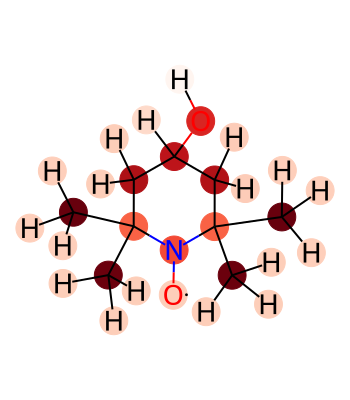

In [193]:
png

In [144]:
# gene_expr

In [145]:
# from fragnet.dataset.dataset import FinetuneDataCDRP

In [146]:
# class args:
#     data_dir='/Users/pana982/projects/cdrp/models/DeepTTC/GDSC_data'

In [147]:
# args = args()

In [140]:
# dataset = FinetuneDataCDRP(target_name='LN_IC50', data_type='exp1s', 
#                            args=args,
#                            use_genes=True)

In [163]:
from fragnet.dataset.fragments import get_3Dcoords

mol = get_3Dcoords(smiles)
conf = mol.GetConformer(id=0)

x = [smiles, [-1], mol, conf, gene_expr.iloc[0,:].values]

from fragnet.dataset.data import CreateDataCDRP

create_data = CreateDataCDRP(data_type='exp1s', create_bond_graph_data=True, 
                                    add_dhangles=False)

ds = create_data.create_data_point(x)

ds

from fragnet.dataset.data import collate_fn_cdrp

test_loader = DataLoader([ds], collate_fn=collate_fn_cdrp, batch_size=1, shuffle=False, drop_last=False)

In [164]:
ds

Data(edge_index=[2, 60], edge_attr=[60, 17], y=[1], x_atoms=[30, 167], frag_index=[2, 10], cnx_attr=[10, 6], x_frags=[6, 167], atom_id_frag_id=[30], n_frags=[1], node_features_bonds=[60, 17], edge_index_bonds=[2, 464], edge_attr_bonds=[464, 1], smiles='CC1(C)CC(O)CC(C)(C)N1[O]', gene_expr=[903], node_feautures_fbondg=[10, 6], edge_index_fbondg=[2, 80], edge_attr_fbondg=[80, 6])

In [165]:
next(iter(test_loader))

{'x_atoms': tensor([[0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 1., 0.],
         [1., 0., 0.,  ..., 0., 1., 0.],
         [1., 0., 0.,  ..., 0., 1., 0.]]),
 'edge_index': tensor([[ 0,  1,  1,  2,  1,  3,  3,  4,  4,  5,  4,  6,  6,  7,  7,  8,  7,  9,
           7, 10, 10, 11, 10,  1,  0, 12,  0, 13,  0, 14,  2, 15,  2, 16,  2, 17,
           3, 18,  3, 19,  4, 20,  5, 21,  6, 22,  6, 23,  8, 24,  8, 25,  8, 26,
           9, 27,  9, 28,  9, 29],
         [ 1,  0,  2,  1,  3,  1,  4,  3,  5,  4,  6,  4,  7,  6,  8,  7,  9,  7,
          10,  7, 11, 10,  1, 10, 12,  0, 13,  0, 14,  0, 15,  2, 16,  2, 17,  2,
          18,  3, 19,  3, 20,  4, 21,  5, 22,  6, 23,  6, 24,  8, 25,  8, 26,  8,
          27,  9, 28,  9, 29,  9]]),
 'frag_index': tensor([[3, 1, 0, 1, 2, 1, 4, 1, 5, 1],
         [1, 3, 1, 0, 1, 2, 1, 4, 1, 5]]),
 'x_frags': tensor([[ 3.,  0.,  0.,  ...,  0.,  4.,

In [ ]:
model_config = root + '/exps/ft/pnnl_set2/fragnet_hpdl_exp1s_h4pt4_10/config_exp100.yaml'
viz = FragNetViz(model_config, 
                 '/Users/pana982/projects/esmi/models/fragnet/fragnet/exps/ft/pnnl_set2/fragnet_hpdl_exp1s_h4pt4_10/ft_100.pt')

In [76]:
viz.calc_weights(smiles)

100%|███████████████████████████████████████████████████| 1/1 [00:00<00:00, 80.39it/s]


0.01402902603149414
0.0016582012176513672


1it [00:00, 60.80it/s]


In [77]:
png = viz.vizualize_atom_weights()

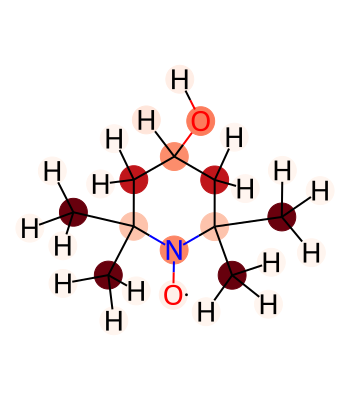

In [78]:
png

In [79]:
model_config = '/Users/pana982/projects/esmi/models/fragnet/fragnet/exps/pt/unimol_exp1s4/config.yaml'

In [80]:
# model = FragNetPreTrainViz(num_layer=args.pretrain.num_layer,
#                         drop_ratio=args.pretrain.drop_ratio,
#                             num_heads=args.pretrain.num_heads,
#                             emb_dim=args.pretrain.emb_dim,
#                             atom_features=args.atom_features,
#                             frag_features=args.frag_features,
#                             edge_features=args.edge_features)

In [81]:
from fragnet.vizualize.model import FragNetPreTrainViz

In [82]:
viz = FragNetViz(model_config, 
                 '/Users/pana982/projects/esmi/models/fragnet/fragnet/exps/pt/unimol_exp1s4/pt.pt',
                'energy')

In [83]:
viz.calc_weights(smiles)

100%|███████████████████████████████████████████████████| 1/1 [00:00<00:00, 76.95it/s]


0.01467132568359375
0.0017189979553222656


1it [00:00, 65.47it/s]


In [84]:
png = viz.vizualize_atom_weights()

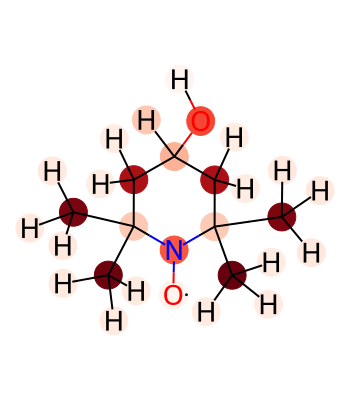

In [85]:
png

In [194]:
model

FragNetFineTuneViz(
  (pretrain): FragNetViz(
    (dropout): Dropout(p=0.0, inplace=False)
    (act): ReLU()
    (layers): ModuleList(
      (0): FragNetLayerA(
        (atom_embed): Linear(in_features=167, out_features=128, bias=True)
        (frag_embed): Linear(in_features=167, out_features=128, bias=True)
        (edge_embed): Linear(in_features=17, out_features=128, bias=True)
        (bond_edge_embed): Linear(in_features=17, out_features=128, bias=True)
        (frag_message_mlp): Linear(in_features=256, out_features=128, bias=True)
        (atom_mlp): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=128, bias=True)
        )
        (frag_mlp): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=128, bias=True)
        )
        (leakyrelu): LeakyReLU(negative_slope=0.2)
    